In [1]:
%cd /app
from torchvision import transforms
from PIL import Image

import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch

class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # замените head классификации COCO на кастомную
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask=None):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

/app


In [2]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


def visualize_predictions(image, outputs, threshold=0.6):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [4]:
device = 'cpu'
id2label = {0: 'Выход трубы из ряда', 1: 'Крип', 2: 'Разрыв', 3: 'Свищ', 4: 'Трещина'}
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model = model.load_from_checkpoint('checkpoints/epoch=449-step=352800.ckpt', lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
# model.cuda()
model.eval()
image = Image.open('checkpoints/test_image.jpeg').convert('RGB')
convert_tensor = transforms.ToTensor()

tensor_image = convert_tensor(image).unsqueeze_(0).to(device)


Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [11]:
outputs = model(pixel_values=tensor_image, pixel_mask=None)

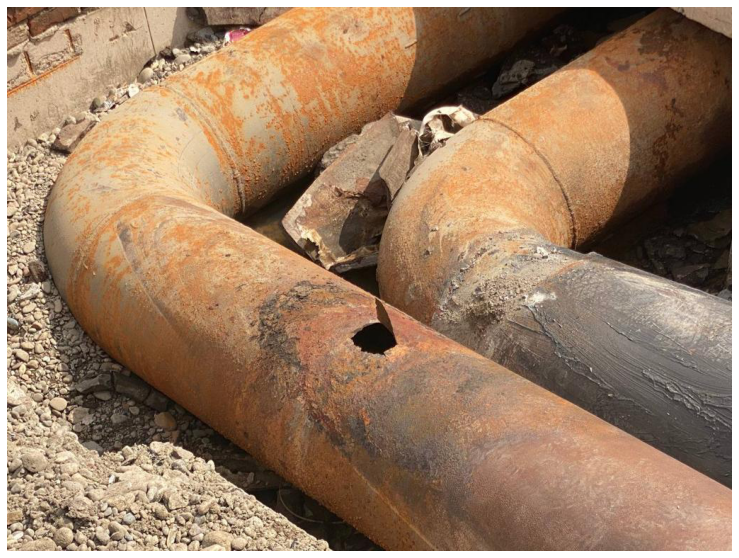

In [12]:
visualize_predictions(image, outputs)

# Оценка модели

In [6]:
!git clone https://github.com/facebookresearch/detr.git
%cd detr

fatal: destination path 'detr' already exists and is not an empty directory.
/app/detr


In [7]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.abspath(os.path.join(img_folder, "train.json" if train else "val.json"))
        self.annfile = ann_file
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [9]:
from transformers import DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
val_dataset = CocoDetection(img_folder='../checkpoints/val/images', feature_extractor=feature_extractor, train=False)
print("Количество примеров валидации:", len(val_dataset))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Количество примеров валидации: 101


In [10]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(val_dataloader))


In [11]:
from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute

In [12]:
from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
model.eval()

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized
    # forward pass
    outputs = model.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

Running evaluation...


  0%|          | 0/101 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.09s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.759
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.613
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.655
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.671
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.179
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.405
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

# model to onnx

In [18]:
filepath = "../checkpoints/detr.onnx"
torch.onnx.export(model, tensor_image, filepath)

/opt/conda/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:562: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attn_weights.size() != (bsz * self.num_heads, tgt_len, src_len):
/opt/conda/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:569: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if attention_mask.size() != (bsz, 1, tgt_len, src_len):
/opt/conda/lib/python3.7/site-packages/transformers/models/detr/modeling_detr.py:592: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be i

In [13]:
import onnx

onnx_model = onnx.load("../checkpoints/detr.onnx")
onnx.checker.check_model(onnx_model)

In [14]:
import onnxruntime as ort
ort.get_device()

'CPU'

In [1]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("../checkpoints/test_images.jpg")

resize = transforms.Resize([960, 1280])
img = resize(img)

# img_ycbcr = img.convert('YCbCr')
# img_y, img_cb, img_cr = img_ycbcr.split()

to_tensor = transforms.ToTensor()
img_y = to_tensor(img)
img_y.unsqueeze_(0)

FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/test_images.jpg'

In [ ]:
import onnxruntime as ort
from tqdm import tqdm

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

providers = [
    ('CUDAExecutionProvider', {
        'device_id': 0,
        'arena_extend_strategy': 'kNextPowerOfTwo',
        'gpu_mem_limit': 2 * 1024 * 1024 * 1024,
        'cudnn_conv_algo_search': 'EXHAUSTIVE',
        'do_copy_in_default_stream': True,
    }),
    'CPUExecutionProvider',
]
ort_session = ort.InferenceSession("../checkpoints/detr.onnx", providers=providers)
ort_session.set_providers(['CPUExecutionProvider'])
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}

In [17]:
ort_outs = ort_session.run(None, ort_inputs)

In [2]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


def visualize_predictions(image, outputs, threshold=0.1):
  # keep only predictions with confidence >= threshold
  probas = torch.from_numpy(outputs[0]).softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(torch.from_numpy(outputs[1])[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)
  
id2label = {0: 'Выход трубы из ряда', 1: 'Крип', 2: 'Разрыв', 3: 'Свищ', 4: 'Трещина'}

In [3]:
image = Image.open('../checkpoints/test_images.jpg').convert('RGB')
visualize_predictions(image, ort_outs)

FileNotFoundError: [Errno 2] No such file or directory: '../checkpoints/test_images.jpg'

In [15]:
class MockDetrOutput(object):
    def __init__(self, logits, pred_boxes, last_hidden_state, encoder_last_hidden_state):
        self.logits = torch.tensor(logits)
        self.pred_boxes = torch.tensor(pred_boxes)
        self.last_hidden_state = torch.tensor(last_hidden_state)
        self.encoder_last_hidden_state = torch.tensor(encoder_last_hidden_state)
        
# test_output = MockDetrOutput(ort_outs[0], ort_outs[1], ort_outs[2], ort_outs[3])

# Оценка

In [27]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "train.json" if train else "val.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target
    



from transformers import DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
val_dataset = CocoDetection(img_folder='../checkpoints/val/images', feature_extractor=feature_extractor, train=False)
print("Количество примеров валидации:", len(val_dataset))


from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
batch = next(iter(val_dataloader))


from datasets import get_coco_api_from_dataset

base_ds = get_coco_api_from_dataset(val_dataset) # this is actually just calling the coco attribute


from datasets.coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

iou_types = ['bbox']
coco_evaluator = CocoEvaluator(base_ds, iou_types) # initialize evaluator with ground truths
device = torch.device("cpu")

print("Running evaluation...")

for idx, batch in enumerate(tqdm(val_dataloader)):
    # get the inputs
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]] # these are in DETR format, resized + normalized
    
    resize = transforms.Resize([960, 1280])
    pixel_values = resize(pixel_values)

    # img_ycbcr = img.convert('YCbCr')
    # img_y, img_cb, img_cr = img_ycbcr.split()

    # to_tensor = transforms.ToTensor()
    # img_y = to_tensor(pixel_values)
    # img_y.unsqueeze_(0)
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(pixel_values)}
    
    # forward pass
    outputs = ort_session.run(None, ort_inputs)
    outputs = MockDetrOutput(outputs[0], outputs[1], outputs[2], outputs[3])
    
    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = feature_extractor.post_process(outputs, orig_target_sizes) # convert outputs of model to COCO api
    res = {target['image_id'].item(): output for target, output in zip(labels, results)}
    coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
coco_evaluator.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Количество примеров валидации: 101
Running evaluation...


  0%|          | 0/101 [00:00<?, ?it/s]

Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.439
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.017
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.503
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.525
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.556
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.133
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.290
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

# model to torchscript

In [13]:
class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # замените head классификации COCO на кастомную
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True,
                                                             torchscript=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask=None):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader






id2label = {0: 'Выход трубы из ряда', 1: 'Крип', 2: 'Разрыв', 3: 'Свищ', 4: 'Трещина'}
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)
model = model.load_from_checkpoint('checkpoints/epoch=449-step=352800.ckpt', lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

input_tensor = torch.rand(1,3,960,1280)
filepath = "checkpoints/detr.pt"

# Creating the trace
traced_model = torch.jit.trace(model, input_tensor)
torch.jit.save(traced_model, filepath)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably

# torchsctipt inference

In [20]:
from PIL import Image
import torchvision.transforms as transforms
import torch
img_name = "121.jpg"
img = Image.open(f"img/val/images/{img_name}")

resize = transforms.Resize([960, 1280])
img = resize(img)

to_tensor = transforms.ToTensor()
input_img = to_tensor(img)
input_img.unsqueeze_(0)


loaded_model = torch.jit.load("checkpoints/detr.pt")
loaded_model.eval()
output = loaded_model(input_img)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To 

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False])
0.1
tensor([[796.5461, 348.9637, 874.1412, 426.9758],
        [679.4283, 256.4419, 906.8168, 515.4511]])
Разрыв
Разрыв


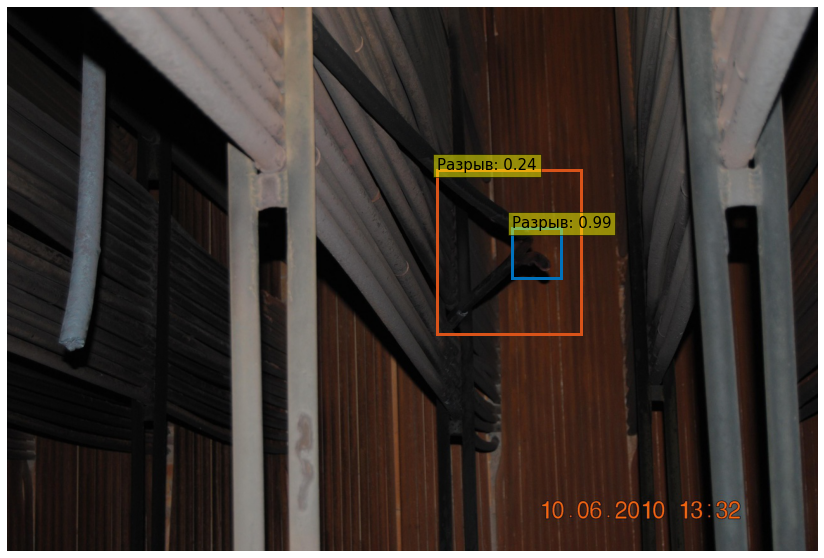

In [21]:
import matplotlib.pyplot as plt

id2label = {0: 'Выход трубы из ряда', 1: 'Крип', 2: 'Разрыв', 3: 'Свищ', 4: 'Трещина'}
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

class MockDetrOutput(object):
    def __init__(self, logits, pred_boxes, last_hidden_state, encoder_last_hidden_state):
        self.logits = torch.tensor(logits)
        self.pred_boxes = torch.tensor(pred_boxes)
        self.last_hidden_state = torch.tensor(last_hidden_state)
        self.encoder_last_hidden_state = torch.tensor(encoder_last_hidden_state)

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        print(id2label[cl.item()])
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


def visualize_predictions(image, outputs, threshold=0.1):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  print(keep)
  print(threshold)
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
  print(bboxes_scaled)
  # plot results

  plot_results(image, probas[keep], bboxes_scaled)




outputs = MockDetrOutput(output[0], output[1], output[2], output[3])
image = Image.open(f'img/val/images/{img_name}').convert('RGB')
visualize_predictions(image, outputs)

# min max predicted bbox

In [22]:
def get_area_of_bbox(bbox):
    return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])


def difference_bboxes(bboxes1, bboxes2):# bbox1 - bbox2
    
    result = bboxes1.copy()
    for bbox2 in bboxes2:
        for bbox1 in bboxes1:
            if bbox1 == bbox2:
                result.remove(bbox1)
    return result

In [82]:
import math
import json
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision.ops.boxes as bops



    

threshold = 0.5
val_ann = json.load(open('img/val/images/val.json'))

probas = outputs.logits.softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > threshold
bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
# print(f'bboxes_scaled: {bboxes_scaled}')

val_image_id = None
for ann_image in val_ann["images"]:
    if ann_image['file_name'] == img_name:
        val_image_id = ann_image['id']
        print(f'val_image_id {val_image_id}')
        break
        
val_bboxes = []
for ann_ann in val_ann['annotations']:
        if ann_ann['image_id'] == val_image_id:
            val_bboxes.append(ann_ann['bbox'])

predicted_val_bboxes = [] # предсказанные валидационные bboxes
correctly_predicted_bboxes = [] # предсказанные bboxes с iou >= 0.5
for p, (xmin, ymin, xmax, ymax) in zip(probas[keep], bboxes_scaled.tolist()):
    cl = p.argmax()
    pred_category_id = cl.item()
    pred_bbox = (xmin, ymin, xmax, ymax)

    for ann_ann in val_ann['annotations']:
        if ann_ann['image_id'] == val_image_id:#and ann_ann['category_id'] == pred_category_id:
            val_bbox = ann_ann['bbox']
            x1,y1,h,w = val_bbox
            val_bbox = (x1,y1,x1+h,y1+w)
            
            # print(f'val_bbox {val_bbox}')
            # print(f'pred_bbox {pred_bbox}')
            
            box1 = torch.tensor([pred_bbox], dtype=torch.float)
            box2 = torch.tensor([val_bbox], dtype=torch.float)
            iou = bops.box_iou(box1, box2)
            # print(f'iou: {iou.item()}')
            
            if iou.item() >= 0.5:
                print(iou.item())
                predicted_val_bboxes.append(ann_ann['bbox'])
                correctly_predicted_bboxes.append(pred_bbox)
                
print(predicted_val_bboxes, val_bboxes)
difference_bboxes(val_bboxes, predicted_val_bboxes)

val_image_id 328
0.882013201713562
0.668764054775238
0.5687219500541687
[[394, 390, 113, 43], [283, 387, 70, 37], [868, 466, 119, 96]] [[351, 432, 48, 36], [868, 466, 119, 96], [283, 387, 70, 37], [394, 390, 113, 43]]


[[351, 432, 48, 36]]

# min max bbox areas from val dataset

In [100]:
val_ann = json.load(open('img/val/images/val.json'))

bboxes_by_categories = {
    "0" : [],
    "1" : [],
    "2" : [],
    "3" : [],
    "4" : [],

}

for ann_ann in val_ann['annotations']:
    val_bbox = ann_ann['bbox']
    x1,y1,h,w = val_bbox
    val_bbox = (x1,y1,x1+h,y1+w)
    bboxes_by_categories[str(ann_ann['category_id'])].append(val_bbox)
    
bboxes_by_categories

area_of_bboxes_by_categories = {
    "0" : {"min": None, "max": None},
    "1" : {"min": None, "max": None},
    "2" : {"min": None, "max": None},
    "3" : {"min": None, "max": None},
    "4" : {"min": None, "max": None},

}


for category_id, bboxes in bboxes_by_categories.items():
    area_of_bboxes = []
    for bbox in bboxes:
        area = get_area_of_bbox(bbox)
        # if area > 500000:
            # print(bbox)
            # break
        area_of_bboxes.append(area)
    # print(area_of_bboxes)
    # break
    area_of_bboxes_by_categories[str(category_id)]["min"] = min(area_of_bboxes)
    area_of_bboxes_by_categories[str(category_id)]["max"] = max(area_of_bboxes)
    
    
area_of_bboxes_by_categories

{'0': {'min': 34121, 'max': 697374},
 '1': {'min': 4251, 'max': 534772},
 '2': {'min': 682, 'max': 944400},
 '3': {'min': 90, 'max': 139956},
 '4': {'min': 1408, 'max': 584960}}

# min max bbox areas from predicted

In [15]:
import json
import onnxruntime as ort
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
import torch


class MockDetrOutput(object):
    def __init__(self, logits, pred_boxes, last_hidden_state, encoder_last_hidden_state):
        self.logits = torch.tensor(logits)
        self.pred_boxes = torch.tensor(pred_boxes)
        self.last_hidden_state = torch.tensor(last_hidden_state)
        self.encoder_last_hidden_state = torch.tensor(encoder_last_hidden_state)


def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


def get_area_of_bbox(bbox):
    return (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])


def difference_bboxes(bboxes1, bboxes2):# bbox1 - bbox2
    
    result = bboxes1.copy()
    for bbox2 in bboxes2:
        for bbox1 in bboxes1:
            if bbox1 == bbox2:
                result.remove(bbox1)
    return result


id2label = {0: 'Выход трубы из ряда', 1: 'Крип', 2: 'Разрыв', 3: 'Свищ', 4: 'Трещина'}
threshold = 0.5

providers = [
        ('CUDAExecutionProvider', {
            'device_id': 0,
            'arena_extend_strategy': 'kNextPowerOfTwo',
            'gpu_mem_limit': 2 * 1024 * 1024 * 1024,
            'cudnn_conv_algo_search': 'EXHAUSTIVE',
            'do_copy_in_default_stream': True,
        }),
        'CPUExecutionProvider',
    ]

ort_session = ort.InferenceSession("checkpoints/detr.onnx", providers=providers)
ort_session.set_providers(['CPUExecutionProvider'])

val_ann = json.load(open('img/val/images/val.json'))

bboxes_by_categories = {
    "0" : [],
    "1" : [],
    "2" : [],
    "3" : [],
    "4" : [],
}

area_of_bboxes_by_categories = {
    "0" : {"min": None, "max": None},
    "1" : {"min": None, "max": None},
    "2" : {"min": None, "max": None},
    "3" : {"min": None, "max": None},
    "4" : {"min": None, "max": None},
}

ratio_of_area_bbox_to_image_shape_by_categories = {
    "0" : [],
    "1" : [],
    "2" : [],
    "3" : [],
    "4" : [],
}

min_max_ratio_of_area_bbox_to_image_shape_by_categories = {
    "0" : {"min": None, "max": None},
    "1" : {"min": None, "max": None},
    "2" : {"min": None, "max": None},
    "3" : {"min": None, "max": None},
    "4" : {"min": None, "max": None},
}

for val_image in val_ann['images']:
    image = Image.open(f"img/val/images/{val_image['file_name']}")
    
    resize = transforms.Resize([960, 1280])
    img = resize(image)

    # img_ycbcr = img.convert('YCbCr')
    # img_y, img_cb, img_cr = img_ycbcr.split()

    to_tensor = transforms.ToTensor()
    img_y = to_tensor(img)
    img_y.unsqueeze_(0)
    ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img_y)}
    output = ort_session.run(None, ort_inputs)
    outputs = MockDetrOutput(output[0], output[1], output[2], output[3])
    # print(outputs.pred_boxes)
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)
    for p, (xmin, ymin, xmax, ymax) in zip(probas[keep], bboxes_scaled.tolist()):
        cl = p.argmax()
        category_id = cl.item()
        bboxes_by_categories[str(category_id)].append((xmin, ymin, xmax, ymax))
        # print(f"get_area_of_bbox({(xmin, ymin, xmax, ymax)}): {get_area_of_bbox((xmin, ymin, xmax, ymax))}")
        # print(f"img_shape: {image.size}")
        # print(f"img_area: {image.size[0] * image.size[1]}")
        # print(f"bbox_area/img_area:  {get_area_of_bbox((xmin, ymin, xmax, ymax)) / (image.size[0] * image.size[1])}")
        ratio_of_area_bbox_to_image_shape_by_categories[str(category_id)].append(get_area_of_bbox((xmin, ymin, xmax, ymax)) / (image.size[0]*image.size[1]))


for category_id, bboxes in bboxes_by_categories.items():
    area_of_bboxes = []
    for bbox in bboxes:
        area = get_area_of_bbox(bbox)
        area_of_bboxes.append(area)
    area_of_bboxes_by_categories[str(category_id)]["min"] = min(area_of_bboxes)
    area_of_bboxes_by_categories[str(category_id)]["max"] = max(area_of_bboxes)
    min_max_ratio_of_area_bbox_to_image_shape_by_categories[str(category_id)]["min"] = min(ratio_of_area_bbox_to_image_shape_by_categories[str(category_id)])
    min_max_ratio_of_area_bbox_to_image_shape_by_categories[str(category_id)]["max"] = max(ratio_of_area_bbox_to_image_shape_by_categories[str(category_id)])

print(area_of_bboxes_by_categories)
print(min_max_ratio_of_area_bbox_to_image_shape_by_categories)



{'0': {'min': 56260.40351650212, 'max': 318895.7549164421}, '1': {'min': 30763.720950172283, 'max': 691081.3120301813}, '2': {'min': 4406.670923575759, 'max': 1000156.6457018703}, '3': {'min': 869.3792481720448, 'max': 17267.993943616748}, '4': {'min': 1348.1809685379267, 'max': 672765.7620313433}}
{'0': {'min': 0.03433862519317756, 'max': 0.23886606762077697}, '1': {'min': 0.004059038815746234, 'max': 0.17999356325174176}, '2': {'min': 0.0013176440144013642, 'max': 0.8139295619318606}, '3': {'min': 0.0005306269825268827, 'max': 0.014052729446302693}, '4': {'min': 0.0008228643606798869, 'max': 0.5474981787364448}}


In [12]:
101851.89498282969 / 1228800

0.08288728432847468

# min max bbox_area/img_shape by categories

In [ ]:
import json
import onnxruntime as ort
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
import torch